In [2]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

c:\Users\s8gre\AppData\Local\Programs\Python\Python39\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


In [4]:
def load_audio_files(path: str, label:str):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))

    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker, _ = os.path.splitext(filename)
        speaker_id, utterance_number = speaker.split("_nohash_")
        utterance_number = int(utterance_number)
    
        # Load audio
        waveform, sample_rate = torchaudio.load(file_path)
        dataset.append([waveform, sample_rate, label, speaker_id, utterance_number])
        
    return dataset

In [5]:
trainset_speechcommands_yes = load_audio_files('./data/SpeechCommands/speech_commands_v0.02/yes', 'yes')
trainset_speechcommands_no = load_audio_files('./data/SpeechCommands/speech_commands_v0.02/no', 'no')

In [5]:
print(f'Length of yes dataset: {len(trainset_speechcommands_yes)}')
print(f'Length of no dataset: {len(trainset_speechcommands_no)}')

Length of yes dataset: 4044
Length of no dataset: 3941


In [8]:
trainloader_yes = torch.utils.data.DataLoader(trainset_speechcommands_yes, batch_size=1,
                                            shuffle=True, num_workers=0)

[tensor([[-0.0028, -0.0054, -0.0034,  ..., -0.0011, -0.0013, -0.0014]]), 16000, 'yes', '004ae714', 0]


In [7]:
trainloader_no = torch.utils.data.DataLoader(trainset_speechcommands_no, batch_size=1,
                                            shuffle=True, num_workers=0)

In [8]:
yes_waveform = trainset_speechcommands_yes[0][0]
yes_sample_rate = trainset_speechcommands_yes[0][1]
print(f'Yes Waveform: {yes_waveform}')
print(f'Yes Sample Rate: {yes_sample_rate}')
print(f'Yes Label: {trainset_speechcommands_yes[0][2]}')
print(f'Yes ID: {trainset_speechcommands_yes[0][3]} \n')

no_waveform = trainset_speechcommands_no[0][0]
no_sample_rate = trainset_speechcommands_no[0][1]
print(f'No Waveform: {no_waveform}')
print(f'No Sample Rate: {no_sample_rate}')
print(f'No Label: {trainset_speechcommands_no[0][2]}')
print(f'No ID: {trainset_speechcommands_no[0][3]}')

Yes Waveform: tensor([[-0.0028, -0.0054, -0.0034,  ..., -0.0011, -0.0013, -0.0014]])
Yes Sample Rate: 16000
Yes Label: yes
Yes ID: 004ae714 

No Waveform: tensor([[0.0072, 0.0061, 0.0055,  ..., 0.0098, 0.0085, 0.0092]])
No Sample Rate: 16000
No Label: no
No ID: 012c8314


In [9]:
def show_waveform(waveform, sample_rate, label):
    print("Waveform: {}\nSample rate: {}\nLabels: {} \n".format(waveform, sample_rate, label))
    new_sample_rate = sample_rate/10
   
    # Resample applies to a single channel, we resample first channel here
    channel = 0
    waveform_transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel,:].view(1,-1))

    print("Shape of transformed waveform: {}\nSample rate: {}".format(waveform_transformed.size(), new_sample_rate))

    plt.figure()
    plt.plot(waveform_transformed[0,:].numpy())

Waveform: tensor([[-0.0028, -0.0054, -0.0034,  ..., -0.0011, -0.0013, -0.0014]])
Sample rate: 16000
Labels: yes 

Shape of transformed waveform: torch.Size([1, 1600])
Sample rate: 1600.0


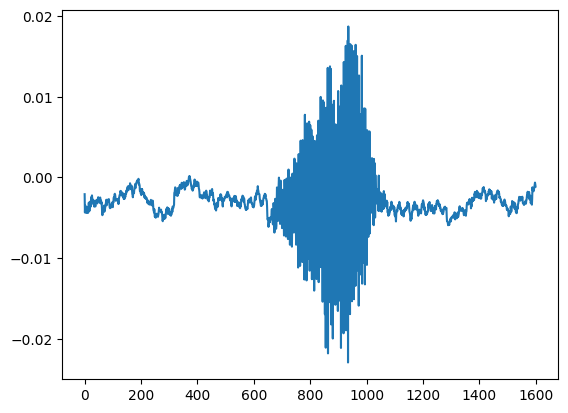

In [10]:
show_waveform(yes_waveform, yes_sample_rate, 'yes')

In [ ]:
show_waveform(no_waveform, no_sample_rate, 'no')

In [17]:
def show_spectrogram(waveform_classA, waveform_classB):
    yes_spectrogram = torchaudio.transforms.Spectrogram()(waveform_classA)
    print("\nShape of yes spectrogram: {}".format(yes_spectrogram.size()))
    
    no_spectrogram = torchaudio.transforms.Spectrogram()(waveform_classB)
    print("Shape of no spectrogram: {}".format(no_spectrogram.size()))

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Features of {}".format('no'))
    plt.imshow(yes_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')
    
    plt.subplot(1, 2, 2)
    plt.title("Features of {}".format('yes'))
    plt.imshow(no_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')  

In [9]:
show_spectrogram(yes_waveform, no_waveform)

NameError: name 'show_spectrogram' is not defined

In [14]:
def show_melspectrogram(waveform,sample_rate):
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate)(waveform)
    print("Shape of spectrogram: {}".format(mel_spectrogram.size()))

    plt.figure()
    plt.imshow(mel_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')

In [ ]:
show_melspectrogram(yes_waveform, yes_sample_rate)

In [16]:
def show_mfcc(waveform,sample_rate):
    mfcc_spectrogram = torchaudio.transforms.MFCC(sample_rate= sample_rate)(waveform)
    print("Shape of spectrogram: {}".format(mfcc_spectrogram.size()))

    plt.figure()
    fig1 = plt.gcf()
    plt.imshow(mfcc_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')
    
    plt.figure()
    plt.plot(mfcc_spectrogram.log2()[0,:,:].numpy())
    plt.draw()

In [ ]:
def create_spectrogram_images(trainloader, label_dir):
    #make directory
    directory = f'./data/spectrograms/{label_dir}/'
    if(os.path.isdir(directory)):
        print("Data exists for", label_dir)
    else:
        os.makedirs(directory, mode=0o777, exist_ok=True)
        
        for i, data in enumerate(trainloader):

            waveform = data[0]
            sample_rate = data[1][0]
            label = data[2]
            ID = data[3]

            # create transformed waveforms
            spectrogram_tensor = torchaudio.transforms.Spectrogram()(waveform)     
            
            fig = plt.figure()
            plt.imsave(f'./data/spectrograms/{label_dir}/spec_img{i}.png', spectrogram_tensor[0].log2()[0,:,:].numpy(), cmap='viridis')


In [ ]:
def create_mfcc_images(trainloader, label_dir):
    #make directory
    os.makedirs(f'./data/mfcc_spectrograms/{label_dir}/', mode=0o777, exist_ok=True)
    
    for i, data in enumerate(trainloader):

        waveform = data[0]
        sample_rate = data[1][0]
        label = data[2]
        ID = data[3]
        
        mfcc_spectrogram = torchaudio.transforms.MFCC(sample_rate= sample_rate)(waveform)

        plt.figure()
        fig1 = plt.gcf()
        plt.imshow(mfcc_spectrogram[0].log2()[0,:,:].numpy(), cmap='viridis')
        plt.draw()
        fig1.savefig(f'./data/mfcc_spectrograms/{label_dir}/spec_img{i}.png', dpi=100)
 
        #spectorgram_train.append([spectrogram_tensor, label, sample_rate, ID])

In [ ]:
create_spectrogram_images(trainloader_yes, 'yes')
create_spectrogram_images(trainloader_no, 'no')